In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.applications import EfficientNetV2B0
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
from mlxtend.plotting import plot_confusion_matrix
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import drive, files


IMG_SIZE = (224,224)
BATCH_SIZE = 32

TRAIN_DIR = '/content/drive/MyDrive/BTMdata/Training'
TEST_DIR = '/content/drive/MyDrive/BTMdata/Testing'

CATEGORIES = ["glioma","meningioma","notumor","pituitary"]



In [ ]:
# Creating training dataset
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (224, 224))
          training_data.append([new_array, class_num])

    random.shuffle(training_data)

create_training_data()
#np.save('train_data.npy', training_data)
print(len(training_data))

print("train")
print()
X = np.array([i[0] for i in training_data]).reshape(-1,224,224,3)
Y = np.array([i[1] for i in training_data])

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)



100%|██████████| 1457/1457 [00:34<00:00, 41.85it/s] 


5712
train



In [ ]:
# Creating testing dataset
testing_data = []

def create_testing_data():
    for category in CATEGORIES:
        path = os.path.join(TEST_DIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
          img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)
          new_array = cv2.resize(img_array, (224, 224))
          testing_data.append([new_array, class_num])

    random.shuffle(testing_data)

create_testing_data()
#np.save('testing_data.npy', testing_data)
print(len(testing_data))

print("testing")
print()
X_test= np.array([i[0] for i in testing_data]).reshape(-1,224,224,3)
Y_test = np.array([i[1] for i in testing_data])


100%|██████████| 300/300 [00:05<00:00, 53.33it/s] 


1311
testing



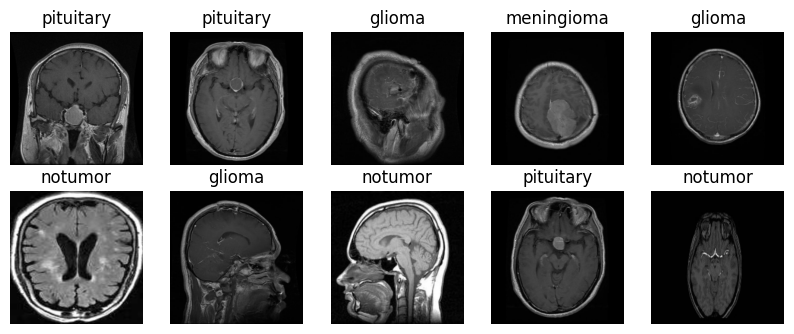

In [ ]:
def display_images(images, labels, classes, num_images=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

display_images(X_train, Y_train, CATEGORIES)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
train_generator = train_datagen.flow(X_train, Y_train, batch_size=32, shuffle=True)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32, shuffle=True)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=32)

In [ ]:
env2 = EfficientNetV2B0(
    weights= 'imagenet',
    include_top=False,
    classes=4,
    input_shape=(224, 224, 3))

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
x = env2.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = Dense(4, activation='softmax')(x)  # Assuming 4 classes

model = Model(inputs=env2.input, outputs=x)

In [ ]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

model.summary()

hist = model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=[tensorboard,checkpoint,reduce_lr])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 138s 605ms/step - loss: 0.4590 - accuracy: 0.8363 - val_loss: 1.3478 - val_accuracy: 0.2835 - lr: 0.0010
Epoch 2/15
143/143 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9236
Epoch 2: val_accuracy improved from 0.28346 to 0.28959, saving model to effnet.h5
143/143 [==============================] - 82s 572ms/step - loss: 0.2073 - accuracy: 0.9236 - val_loss: 1.4126 - val_accuracy: 0.2896 - lr: 0.0010
Epoch 3/15
143/143 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9525
Epoch 3: val_accuracy did not improve from 0.28959
143/143 [==============================] - 78s 547ms/step - loss: 0.1368 - accuracy: 0.9525 - val_loss: 1.6237 - val_accuracy: 0.2843 - lr: 0.0010
Epoch 4/15
143/143 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9659
Epoch 4: val_accuracy did not improve from 0.28959

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
143/143 [

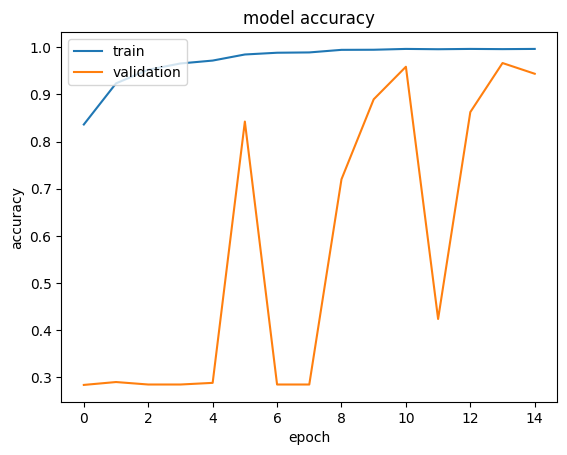

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
preds = model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

41/41 [==============================] - 17s 426ms/step - loss: 0.1639 - accuracy: 0.9519
Loss = 0.16392609477043152
Test Accuracy = 0.9519450664520264


1/1 [==============================] - 2s 2s/step


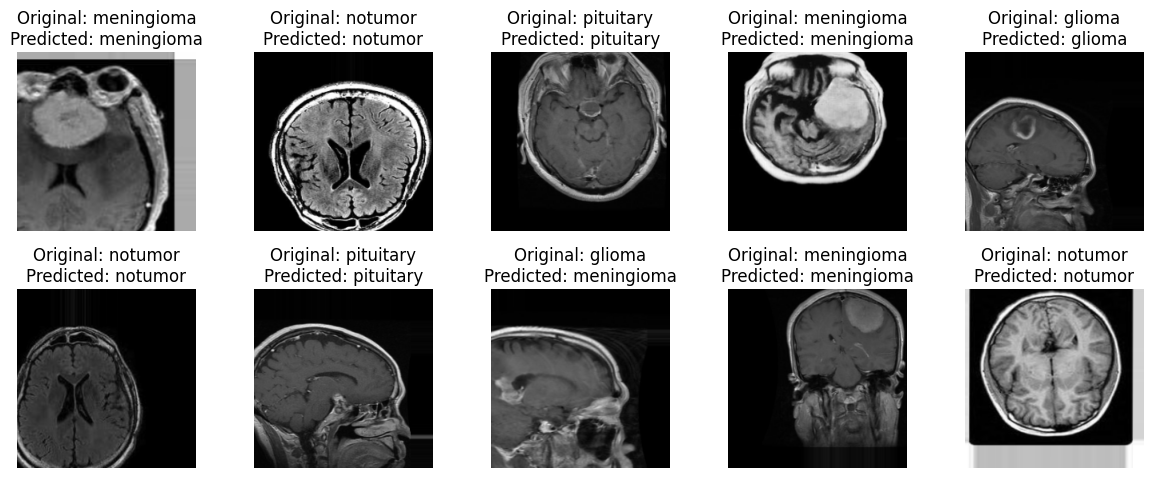

In [ ]:
test_images, test_labels = test_generator.next()
num_images_to_display = 10

predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

plt.figure(figsize=(12, 12))
for i in range(num_images_to_display):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f'Original: {CATEGORIES[test_labels[i]]}\nPredicted: {CATEGORIES[predicted_labels[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class_names = ["glioma", "meningioma", "notumor", "pituitary"]
print(classification_report(test_labels, predicted_labels, target_names=class_names))

# Compute confusion matrix
conf_mat = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_mat)

# Manual Calculation of Precision, Recall, and F-measure
tp = np.diag(conf_mat)
fp = np.sum(conf_mat, axis=0) - tp
fn = np.sum(conf_mat, axis=1) - tp

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_measure = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


              precision    recall  f1-score   support

      glioma       1.00      0.86      0.92         7
  meningioma       0.92      1.00      0.96        11
     notumor       1.00      1.00      1.00        10
   pituitary       1.00      1.00      1.00         4

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32

Confusion Matrix:
[[ 6  1  0  0]
 [ 0 11  0  0]
 [ 0  0 10  0]
 [ 0  0  0  4]]
Precision: [1.         0.91666667 1.         1.        ]
Recall: [0.85714286 1.         1.         1.        ]
F-measure: [0.92307692 0.95652174 1.         1.        ]


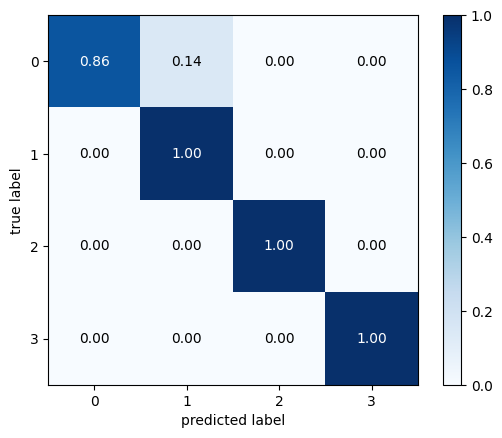

In [ ]:
multiclass = conf_mat

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
plt.show()

In [ ]:
model.save('BTDmodel1076.h5')
files.download('effnet.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>